In [1]:
from sklearnex import patch_sklearn
patch_sklearn()
import pandas as pd
import nltk
import string,re
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (ConfusionMatrixDisplay,classification_report,accuracy_score,
                            precision_score,roc_auc_score)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as pp

pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_rows', 1000) 

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
df_cleaned = pd.read_csv("../dataset/vax_tweets_sentiment_cleaned.csv")

In [3]:
df_cleaned.head()

,orig_text,sentiment,user_name,date,hashtags,cleaned_text
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,neutral,Rachel Roh,2020-12-20,['PfizerBioNTech'],same folks daikon paste could treat cytokine storm
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",positive,Albert Fong,2020-12-13,NaN,while world wrong side history year hopefully biggest vaccination effort ev
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,neutral,eli🇱🇹🇪🇺👌,2020-12-12,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",russian vaccine created last years
3,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",neutral,Charles Adler,2020-12-12,NaN,facts immutable senator even not ethically sturdy enough acknowledge were born
4,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,neutral,Citizen News Channel,2020-12-12,"['whereareallthesickpeople', 'PfizerBioNTech']",explain again need vaccine


In [4]:
#Split dataset into training and test set

x = df_cleaned['cleaned_text']
y = df_cleaned['sentiment']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

In [5]:
def create_grid_search(ml_algo):
    tfidf = TfidfVectorizer()
  
    param_grid = {'rf__max_depth': [300,500,600],
                  'rf__min_samples_leaf': [1,2],
                  'rf__n_estimators': [50,80,100],
                 'tfidf__ngram_range':[(1,1),(1,2)],
                 'tfidf__max_features':[4000,6000,None]}
                        
    pipe = Pipeline(steps=[("tfidf", tfidf), ("rf", ml_algo)])
    
    search = GridSearchCV(pipe, param_grid, cv=10, scoring="balanced_accuracy", n_jobs=-1)
    return search

In [6]:
#Run gridsearchcv to find best parameter for tfidf and machine learning algorithm

rf = RandomForestClassifier(random_state=1337, n_jobs=-1)
model_grid_search = create_grid_search(rf)

model_grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1337))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [300, 500, 600],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__n_estimators': [50, 80, 100],
                         'tfidf__max_features': [4000, 6000, None],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='balanced_accuracy')

In [7]:
print(model_grid_search.best_estimator_)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=4000, ngram_range=(1, 2))),
                ('rf',
                 RandomForestClassifier(max_depth=600, n_estimators=50,
                                        n_jobs=-1, random_state=1337))])


In [8]:
tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=4000)
tfidf.fit(X_train)

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [9]:
#Undersampling functions

def undersampling(ml_algo):
    result = pd.DataFrame()
    no_of_sample = pd.DataFrame()
    
    for sampler,index_text in [(TomekLinks(sampling_strategy = ['neutral'], n_jobs=-1),'RF+TomekLinks')]:
                   
        us_xtrain_tfidf, us_train_y = sampler.fit_resample(X_train_tfidf, y_train)
        ml_algo.fit(us_xtrain_tfidf,us_train_y)
        
        result = pd.concat([result,evaluate(ml_algo,index_text)])
    return result 

In [10]:
#Oversampling functions

def oversampling(ml_algo):
    result = pd.DataFrame()
    for sampler,index_text in [(SMOTE(sampling_strategy={'positive': 6000,'negative': 6000},random_state=777,
                                     n_jobs=-1), 'RF+SMOTE')]:
        
        os_xtrain_tfidf, os_train_y = sampler.fit_resample(X_train_tfidf, y_train)
        ml_algo.fit(os_xtrain_tfidf,os_train_y)

        result = pd.concat([result,evaluate(ml_algo,index_text)])
    return result 

In [20]:
#Oversampling + Undersampling functions

def over_under_sampling(ml_algo):
    result = pd.DataFrame()
    
      
    for sampler_over,index_text_over in [(SMOTE(sampling_strategy={'positive': 6000,'negative': 6000},
                                               random_state=777, n_jobs=-1), 'SMOTE')]:
        for sampler_under,index_text_under in [(TomekLinks(sampling_strategy = ['neutral'], n_jobs=-1),
                                                'TomekLinks')]:
            
            over = sampler_over
            under = sampler_under
    
            steps = [('o', over), ('u', under), ('m', ml_algo)]
            pipeline = pp(steps=steps)
    
            pipeline.fit(X_train_tfidf, y_train)
            result = pd.concat([result,evaluate(ml_algo,"RF+"+index_text_over+"+"+index_text_under)])
    return result  

In [21]:
#Classification performance evaluation

def evaluate(model,index_text):
    predict = model.predict(X_test_tfidf)
    
    class_report = classification_report(y_test,predict,output_dict=True)
    accuracy = class_report['accuracy']
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']
    f1 = class_report['weighted avg']['f1-score']
    
    predict_proba = model.predict_proba(X_test_tfidf)
    roc_auc = roc_auc_score(y_test, predict_proba, average="weighted", multi_class="ovr")
    
    print("\n"+index_text+"\n")
    print(classification_report(y_test,predict))
    
    print("\nROC AUC: " + str(roc_auc))
    
    print("\nConfusion Matrix:\n")
    ConfusionMatrixDisplay.from_predictions(y_test, predict)
    plt.show()
    
    return pd.DataFrame(
        data={"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1, 
              "ROC AUC": roc_auc},
        index=[index_text]
    )


Random Forest

              precision    recall  f1-score   support

    negative       0.75      0.38      0.51       839
     neutral       0.79      0.93      0.85      3334
    positive       0.81      0.67      0.73      1170

    accuracy                           0.79      5343
   macro avg       0.78      0.66      0.70      5343
weighted avg       0.78      0.79      0.77      5343


ROC AUC: 0.8735424362718738

Confusion Matrix:



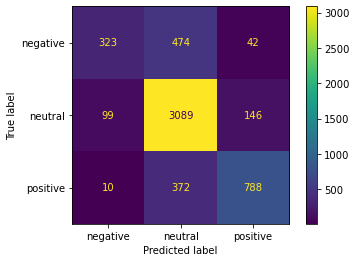

In [22]:
#Random Forest using original dateset

rf = RandomForestClassifier(max_depth=600, n_estimators=50,n_jobs=-1, random_state=1337)
rf.fit(X_train_tfidf,y_train)

eval_result = evaluate(rf,"Random Forest")


RF + Class Weight Balanced

              precision    recall  f1-score   support

    negative       0.69      0.42      0.52       839
     neutral       0.78      0.92      0.84      3334
    positive       0.81      0.64      0.72      1170

    accuracy                           0.78      5343
   macro avg       0.76      0.66      0.70      5343
weighted avg       0.78      0.78      0.77      5343


ROC AUC: 0.8649035503844168

Confusion Matrix:



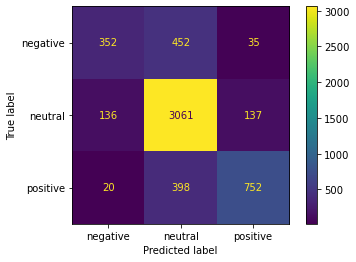

In [23]:
#Random Forest using class weight balanced parameter on original dataset 

rf_weight = RandomForestClassifier(max_depth=600, n_estimators=50,n_jobs=-1, random_state=1337,
                                   class_weight="balanced")

rf_weight.fit(X_train_tfidf,y_train)

eval_result = pd.concat([eval_result,evaluate(rf_weight,"RF + Class Weight Balanced")])


RF+TomekLinks

              precision    recall  f1-score   support

    negative       0.73      0.39      0.51       839
     neutral       0.79      0.92      0.85      3334
    positive       0.80      0.68      0.74      1170

    accuracy                           0.79      5343
   macro avg       0.77      0.66      0.70      5343
weighted avg       0.78      0.79      0.77      5343


ROC AUC: 0.8700864018367982

Confusion Matrix:



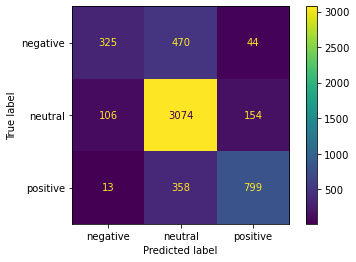

In [24]:
#Random Forest using undersampled dataset

rf = RandomForestClassifier(max_depth=600, n_estimators=50,n_jobs=-1, random_state=1337)
eval_result = pd.concat([eval_result,undersampling(rf)])


RF+SMOTE

              precision    recall  f1-score   support

    negative       0.67      0.41      0.50       839
     neutral       0.78      0.92      0.84      3334
    positive       0.82      0.64      0.72      1170

    accuracy                           0.78      5343
   macro avg       0.76      0.65      0.69      5343
weighted avg       0.77      0.78      0.76      5343


ROC AUC: 0.8599057674264728

Confusion Matrix:



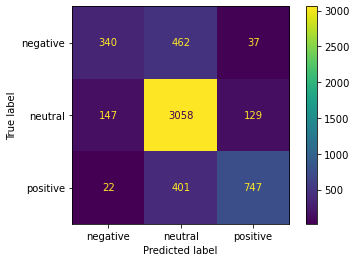

In [25]:
#Random Forest using oversampled dataset

eval_result = pd.concat([eval_result,oversampling(rf)])


RF+SMOTE+TomekLinks

              precision    recall  f1-score   support

    negative       0.68      0.41      0.51       839
     neutral       0.78      0.92      0.84      3334
    positive       0.81      0.64      0.72      1170

    accuracy                           0.78      5343
   macro avg       0.76      0.65      0.69      5343
weighted avg       0.77      0.78      0.76      5343


ROC AUC: 0.8576834990206018

Confusion Matrix:



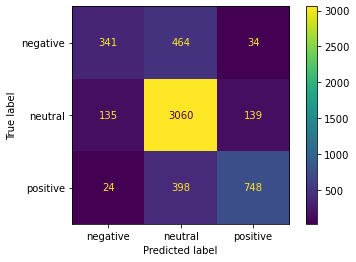

In [26]:
#Random Forest using oversampled & undersampled dataset 

eval_result = pd.concat([eval_result,over_under_sampling(rf)])

In [27]:
#Random Forest performance comparison between original and resampled dataset 

eval_result

,Accuracy,Precision,Recall,F1-Score,ROC AUC
Random Forest,0.786075,0.784045,0.786075,0.770966,0.873542
RF + Class Weight Balanced,0.779525,0.775400,0.779525,0.766622,0.864904
RF+TomekLinks,0.785701,0.782015,0.785701,0.771205,0.870086
RF+SMOTE,0.775781,0.770710,0.775781,0.762302,0.859906
RF+SMOTE+TomekLinks,0.776530,0.771787,0.776530,0.762949,0.857683


In [28]:
rf = RandomForestClassifier(max_depth=600, n_estimators=50,n_jobs=-1, random_state=1337)
rf.fit(X_train_tfidf,y_train)

tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=4000)

pipe_model = Pipeline(steps=[("tfidf", tfidf), ("rf", rf)])

pipe_model.fit(X_train,y_train)

joblib.dump(pipe_model, './model/rf_model.joblib')

['./model/rf_model.joblib']